In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import anndata as ad
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import axis
from normalize import *
from norm_plots import *
from test_model import test_abundance

ROSMAP_PATH = 'ROSMAP_clinical.csv'
CT_COUNTS_META_PATH = 'ct_counts_public_meta.h5ad'

ROSMAP_data = pd.read_csv(ROSMAP_PATH)
ct_counts_metadata = ad.read_h5ad(CT_COUNTS_META_PATH)

ROSMAP_data = ROSMAP_data.convert_dtypes()
ct_counts_metadata.obs = ct_counts_metadata.obs.convert_dtypes()

In [2]:
from outliers import *

normalize_l1(ct_counts_metadata)
calculate_ct_per_median(ct_counts_metadata, 'Exc RELN CHD7', normalize_first=False, layer='norm', column_name='RELN_p_ctm', replace_infs=99999)

ct_counts_metadata.obs

KeyError: 'RELN_p_ctm'

In [ ]:
# Get the threshold value
count_filter = ct_counts_metadata.obs['RELN_p_ctm'] > 10

def _categorize_RELN(value) -> str:
    r: str
    if value < 10:
        r = 'lowRELN'
    elif 10 <= value < 25:
        r = 'midRELN'
    elif value >= 25:
        r = 'highRELN'
    return r

cogdx_map = {1: 'H', 2: 'M', 3: 'M', 4: 'AD', 5: 'AD', 6: 'O'}

high_RELN_samples = ct_counts_metadata.obs[count_filter]
ct_counts_metadata.obs['RELN_cat'] = ct_counts_metadata.obs.apply(lambda row: _categorize_RELN(row['RELN_p_ctm']), axis=1)
ct_counts_metadata.obs['cog_cat'] = ct_counts_metadata.obs.apply(lambda row: cogdx_map[row['cogdx']], axis=1)

RELN_contingency = ct_counts_metadata.obs.value_counts(['RELN_cat', 'cog_cat'])
RELN_contingency

RELN_cat  cog_cat
lowRELN   AD         150
          H          138
          M          101
          O           11
highRELN  AD          10
          H            6
          M            5
midRELN   M            4
          H            2
Name: count, dtype: int64

In [ ]:
# Chi squared

from scipy.stats import chisquare

res = chisquare(RELN_contingency['highRELN'])
res.pvalue


0.36787944117144245

/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jacob/Documents/BEP/bsc-thesis-scripts/.venv/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


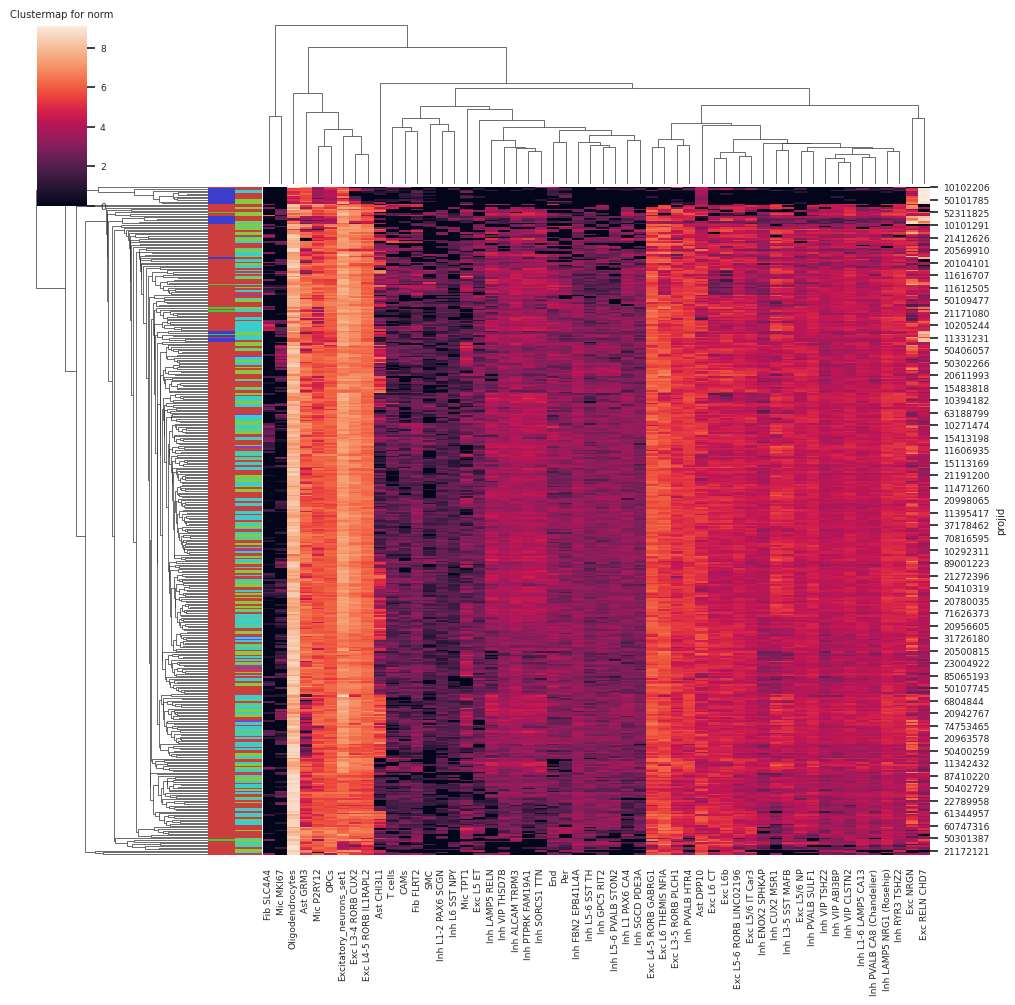

In [ ]:
lut = dict(zip(ct_counts_metadata.obs['RELN_cat'].unique(), "rbg"))
row_colors = ct_counts_metadata.obs['RELN_cat'].map(lut)
normalize_l1(ct_counts_metadata)
generate_clustermap(ct_counts_metadata, 'norm', color_by=['RELN_cat', 'cog_cat'])